In [ ]:
Owner: Nassib Chaya

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import set_trace

def check_type(y,t): # Ensure Inumpyut is Correct
    return y.dtype == np.floating and t.dtype == np.floating

class _Integrator():
    
    def integrate(self,func,y0,t):
        time_delta_grid = t[1:] - t[:-1]
        
        y = np.zeros((y0.shape[0],t.shape[0]))
        y[:,0] = y0
        
        # Euler Step or Runge-Kutta Second Order Integration Step
        for i in range(time_delta_grid.shape[0]):
            y[:,i+1] = time_delta_grid[i]*func(y[:,i],t[i])+y[:,i] # Euler Integration Step
            
            #Un-Comment the next three lines to use the Runge-Kutta Second Order Integration
            #k1=(1/2)*time_delta_grid[i]*func(y[:,i],t[i])
            #breakpoint()
            #y[:,i+1] = y[:,i]+time_delta_grid[i]*func(y[:,i]+k1,t[i]+time_delta_grid[i]/2)
            
            
        return y
       
        #Runge-Kutta Fourth Order Integration Step
        #for i in range(time_delta_grid.shape[0]):
            #k1 = func(y[:,i], t[i])# RK4 Integration Steps replace Euler's Updation Steps
            #half_step = t[i] + time_delta_grid[i] / 2
            #k2 = func(y[:,i] + time_delta_grid[i] * k1 / 2, half_step)
            #k3 = func(y[:,i] + time_delta_grid[i] * k2 / 2, half_step)
            #k4 = func(y[:,i] + time_delta_grid[i] * k3, t[i] + time_delta_grid[i])
            #y[:,i+1]= (k1 + 2 * k2 + 2 * k3 + k4) * (time_delta_grid[i] / 6) + y[:,i]
        #return y
        

def odeint_rk4(func,y0,t):
    y0 = np.array(y0)
    t = np.array(t)
    if check_type(y0,t):
        return _Integrator().integrate(func,y0,t)
    else:
        print("error encountered")

In [23]:
C_m = 1      # Membrane Capacitance

g_K = 10
E_K = -95

g_Na = 100
E_Na = 50 

g_L = 0.15
E_L = -55

In [36]:
def f(x):
    
    if abs(x)<1e-12: 
        x=1
    elif x < -20:
        ex = np.exp(x)
        x = -x*ex/(1-ex)
    else: 
        x = x/(1-np.exp(-x))
    return x

def g(x):
    if abs(x)<1e-12: 
        x=1
    else:
        x = x/(np.exp(x)-1)
    return x

def h(x):
    if x < -20:
        x = np.exp(x)/(np.exp(x)+1)
    else: x = 1/(1+np.exp(-x))
    return x

def K_prop(v):

#αn(V ) = 0.032(V + 52)/(1 − exp(−(V + 52)/5))
    def alpha_n(v):
        u= (v+52)/5
        return 0.032*5*f(u)
    beta_n=0.5*np.exp(-(v+65)/80)

    def n_inf(v):
        return (alpha_n(v)/(alpha_n(v)+ beta_n))
        #set_trace()
    def tau_n(v):
        return (1/(alpha_n(v)+beta_n))
    #set_trace()
    return n_inf(v), tau_n(v)


def Na_prop(v):
    
#αm(V) = 0.32(V + 54)/(1 − exp(−(V + 54)/4))
#βm (V ) = 0.28(V + 27)/(exp((V + 27)/5) − 1)

    def alpha_m(v):
        u = (v+54)/4
        return 4*0.32*f(u)
    
    def beta_m(v):
        u =(v+27)/5
        return 5*0.28*g(u)

    def m_inf(v):
        return (alpha_m(v)/(alpha_m(v)+beta_m(v)))
    
    def tau_m(v):
        return (1 / (alpha_m(v) + beta_m(v)))

#αh(V) = 0.128 exp(−(V + 50)/18)
#βh(V) = 4/(1 + exp(−(V + 27)/5)

    alpha_h = 0.128*np.exp(-(v+50)/18)
                                 
    def beta_h(v):
        u = (v+27)/5
        return 4*h(u)
    
    def h_inf(v):
        return (alpha_h/(alpha_h+beta_h(v)))
    
    def tau_h(v):
        return 1/(alpha_h+beta_h(v))
    #set_trace()
    
    return m_inf(v), tau_m(v), h_inf(v), tau_h(v)


In [38]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

In [40]:
def gPot(n):
    return g_K * n**4

def gSod():
    return 

In [42]:

def run_HH(v_clamp):
    
    def dXdt(X,t):
        V = v_clamp
        #V = X[0:1]
        m = X[0:1]
        h = X[1:2]
        n = X[2:3]

        #dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
        # Here the current injection I_injected = 5 uA
        
        
        
        n0,tn = K_prop(V)
        #set_trace()
        m0,tm,h0,th = Na_prop(V)
        
        dmdt = - (1.0/tm)*(m-m0)
        dhdt = - (1.0/th)*(h-h0)
        dndt = - (1.0/tn)*(n-n0)

        out = np.concatenate([dmdt,dhdt,dndt],0)
        return out

    V=v_clamp
    epsilon = 0.01
    t = np.arange(0, 30, epsilon)
    y0 = np.float64([0,1,0])
    
    state = odeint_rk4(dXdt, y0, t)
    

    #V = state[3]
    m = state[0]
    h = state[1]
    n = state[2]
    
    i_na = I_Na(V, m, h)
    i_k = I_K(V, n)
    i_l = I_L(V)
    i_m = i_na + i_k + i_l
    
    fig, ax = plt.subplots(1)
    ax.set_title("Voltage Clamp = " + str(v_clamp) + "V")
    ax.set_xlabel("Time")
    ax.plot(t, m**3, label = "m^3")
    ax.plot(t, h, label = "h")
    ax.plot(t, m**3*h, label= "m^3h")
    ax.legend()
    
    return

##  1


In the voltage clamp simulation the direction and magnitude of the sodium ion currents depend on the difference between the membrane potential and the sodium equilibrium potential. It also depends on the timing of how sodium channels open and close in response to voltage changes. When the membrane potential is set to 0 mV, the activity of sodium entering the cell is relativity low. At 30 mV the increased membrane potential creates a stronger force, which leads to a larger sodium current into the cell that soon fades as the inactivation process begins. At 60 mV the membrane potential exceeds the sodium reverse potential which causes the direction of the sodium current move out the cell rather than in. Within all models of action potentials, sodium ions initially move into the cell during the early phase of the voltage step. The extent and direction of the movement of sodium ions depends on the level of depolarization and the behavior of the inactivation mechanism.


/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_79891/3242589709.py:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


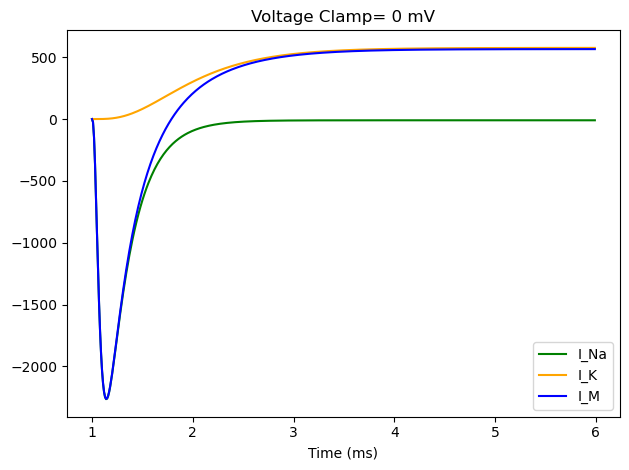

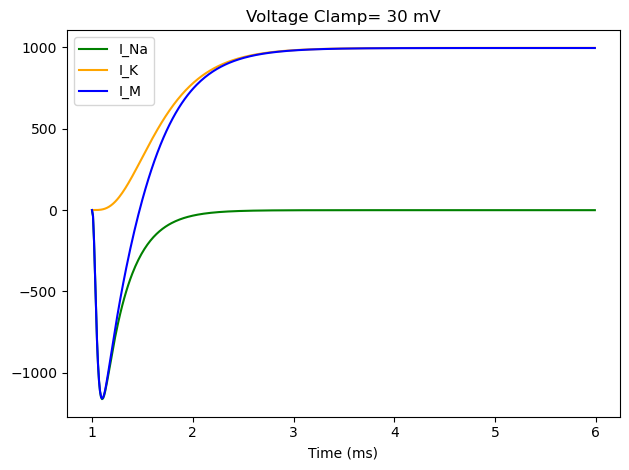

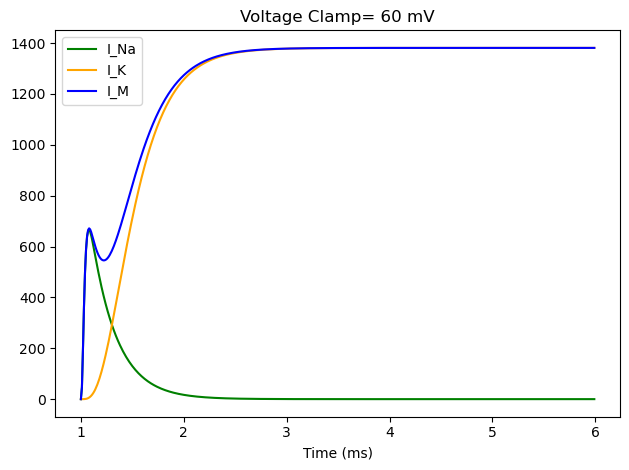

In [45]:
### Three different plots for each step

def run_HH_exp(v_clamp):
    v_rest = -65 
    epsilon = 0.01 
    t = np.arange(0, 6, epsilon) 
    y0 = np.float64([0, 1, 0])
    
    fig, ax = plt.subplots(1)
    
    def dXdt(X, t):
        V = v_clamp
        m = X[0:1]
        h = X[1:2]
        n = X[2:3]

        n0, tn = K_prop(V)
        m0, tm, h0, th = Na_prop(V)
        
        dmdt = - (1.0 / tm) * (m - m0)
        dhdt = - (1.0 / th) * (h - h0)
        dndt = - (1.0 / tn) * (n - n0)

        return np.concatenate([dmdt, dhdt, dndt], 0)
    
    state = odeint_rk4(dXdt, y0, t[t >= 1])
    
    m = state[0]
    h = state[1]
    n = state[2]
    
    i_na = I_Na(v_clamp, m, h)
    i_k = I_K(v_clamp, n)
    i_total = i_na + i_k
    
    ax.plot(t[t >= 1], i_na, label='I_Na', linestyle='solid', color='green')
    ax.plot(t[t >= 1], i_k, label='I_K', linestyle='solid', color='orange')
    ax.plot(t[t >= 1], i_total, label='I_M', linestyle='solid', color='blue')
    ax.set_title('Voltage Clamp= ' + str(v_clamp) + ' mV')
    ax.set_xlabel('Time (ms)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

run_HH_exp(0)
run_HH_exp(30)
run_HH_exp(60)



/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_79891/3242589709.py:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


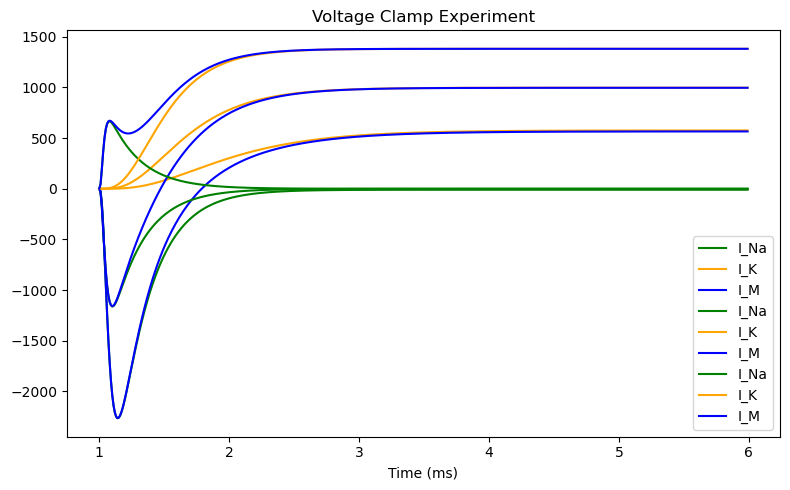

In [47]:
### One plot for all steps

def run_HH_exp():
    v_rest = -65 
    epsilon = 0.01
    t = np.arange(0, 6, epsilon)
    y0 = np.float64([0, 1, 0])
    
    voltage_steps = [0, 30, 60]
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    for v_clamp in voltage_steps:
        def dXdt(X, t):
            V = v_clamp
            m = X[0:1]
            h = X[1:2]
            n = X[2:3]

            n0, tn = K_prop(V)
            m0, tm, h0, th = Na_prop(V)
            
            dmdt = - (1.0 / tm) * (m - m0)
            dhdt = - (1.0 / th) * (h - h0)
            dndt = - (1.0 / tn) * (n - n0)

            return np.concatenate([dmdt, dhdt, dndt], 0)
        
        state = odeint_rk4(dXdt, y0, t[t >= 1])
        
        m = state[0]
        h = state[1]
        n = state[2]
        
        i_na = I_Na(v_clamp, m, h)
        i_k = I_K(v_clamp, n)
        i_total = i_na + i_k
        
        ax.plot(t[t >= 1], i_na, label='I_Na', linestyle='solid', color='green')
        ax.plot(t[t >= 1], i_k, label='I_K', linestyle='solid', color='orange')
        ax.plot(t[t >= 1], i_total, label='I_M', linestyle='solid', color='blue')
    
    ax.set_title('Voltage Clamp Experiment')
    ax.set_xlabel('Time (ms)')
    ax.legend()
    plt.tight_layout()
    plt.show()

run_HH_exp()

## 2: Activation, Inactivation, Time Constant Plot

The activation and inactivation curves within the diagram above show the likelyhood of the channels openning or clossing at a given membrane potential. The sodium and potassium activation curve rises as the voltage increases. This means sodium channels open easily with depolarization and the inactivation curve falls with voltage. This shows that sodium channels close more quickly at high voltage. It reflects how potassium channels open in response to depolarization. 


In [ ]:
voltages = np.linspace(-100, 50, 200)

m_inf_vals = []
tau_m_vals = []
h_inf_vals = []
tau_h_vals = []
n_inf_vals = []
tau_n_vals = []
    
for v in voltages:
    m_inf, tau_m, h_inf, tau_h = Na_prop(v)  
    m_inf_vals.append(m_inf)
    tau_m_vals.append(tau_m)
    h_inf_vals.append(h_inf)
    tau_h_vals.append(tau_h)
    
    n_inf, tau_n = K_prop(v) 
    n_inf_vals.append(n_inf)
    tau_n_vals.append(tau_n)

In [53]:
def plot_activation_inactivation():
    plt.figure(figsize=(10, 5))
    plt.plot(voltages, m_inf_vals, label='m∞', color='blue')
    plt.plot(voltages, h_inf_vals, label='h∞', color='red')
    plt.plot(voltages, n_inf_vals, label='n∞', color='green')
    plt.xlabel('Voltage (mV)')
    plt.ylabel('Steady-state value')
    plt.title('Activation & Inactivation Curves')
    plt.legend()
    plt.show()

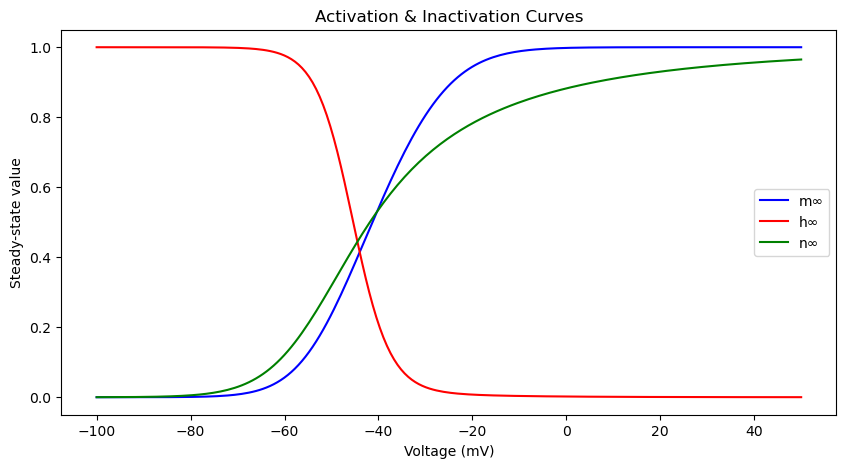

In [55]:
plot_activation_inactivation()

In [76]:
def plot_time_constants():
    plt.figure(figsize=(10, 5))
    plt.plot(voltages, tau_m_vals, label='Tm (Na activation)', color='blue')
    plt.plot(voltages, tau_h_vals, label='Th (Na inactivation)', color='red')
    plt.plot(voltages, tau_n_vals, label='Tn (K activation)', color='green')
    plt.xlabel('Voltage (mV)')
    plt.ylabel('Time constant (ms)')
    plt.title('Time Constants of Gating Variables')
    plt.legend()
    plt.show()

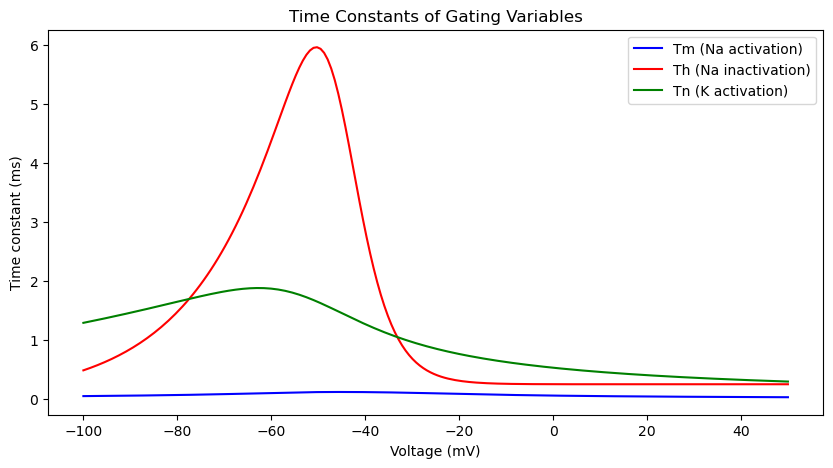

In [78]:
plot_time_constants()

## 3: Unclamped Voltage 

When a current is applied the neuron reacts based on both the size and the frequency of the input. At low frequencies the membrane can follow each wave and action potentials can be triggered in a regular pattern. At very high frequencies the cell will stop firing or may not respond to another stimulation. This shows that the neuron acts like a filter in which that it does not respond the same way to all frequencies. When comparing Euler and RK methods it becomes clear that RK is more stable and Euler gives a rougher result and struggles during fast changes in voltage.


/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_79891/3242589709.py:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


w = 10 Hz: max error = 0.0000 mV, mean error = 0.0000 mV
w = 100 Hz: max error = 0.0000 mV, mean error = 0.0000 mV
w = 1000 Hz: max error = 0.0000 mV, mean error = 0.0000 mV


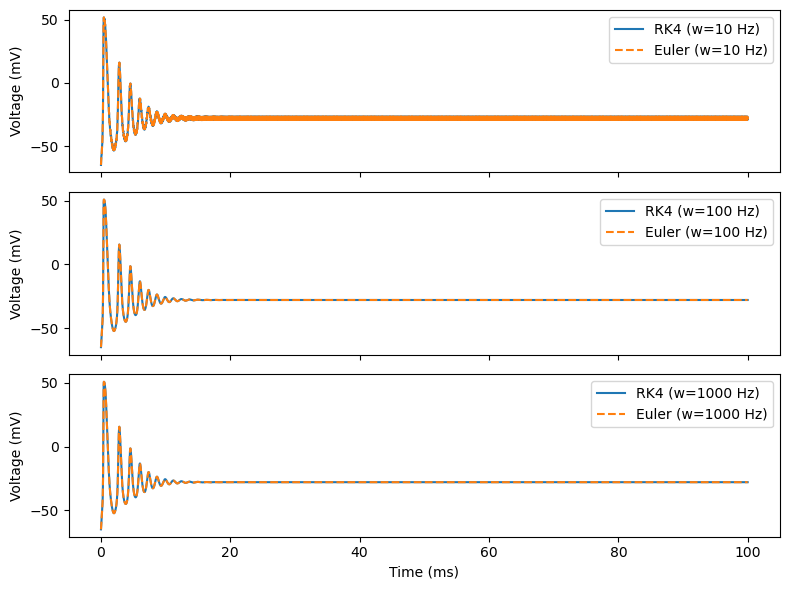

In [83]:
def run_HH_sine():
    epsilon = 0.01
    t = np.arange(0, 100, epsilon)
    y0 = np.float64([-65, 0, 1, 0])
    
    w_values = [10, 100, 1000]
    amplitude = 80
    
    fig, ax = plt.subplots(len(w_values), 1, figsize=(8, 6), sharex=True)
    
    def dXdt(X, t, w):
        
        V = X[0:1]
        m = X[1:2]
        h = X[2:3]
        n = X[3:4]

        I_ext = amplitude * (np.sin(2 * np.pi * w * t)+1)

        n0, tn = K_prop(V)
        m0, tm, h0, th = Na_prop(V)
        
        dVdt = (I_ext - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
        dmdt = - (1.0 / tm) * (m - m0)
        dhdt = - (1.0 / th) * (h - h0)
        dndt = - (1.0 / tn) * (n - n0)

        return np.concatenate([dVdt, dmdt, dhdt, dndt], 0)
    
    for i, w in enumerate(w_values):
        state_rk4 = odeint_rk4(lambda X, t: dXdt(X, t, w), y0, t)
        V_rk4 = state_rk4[0]
        
        state_euler = np.zeros_like(state_rk4)
        state_euler[:, 0] = y0
        for j in range(len(t) - 1):
            state_euler[:, j + 1] = state_euler[:, j] + epsilon * dXdt(state_euler[:, j], t[j], w)
        V_euler = state_euler[0]
        
        abs_error = np.abs(V_rk4 - V_euler)
        max_error = np.max(abs_error)
        mean_error = np.mean(abs_error)
        print(f"w = {w} Hz: max error = {max_error:.4f} mV, mean error = {mean_error:.4f} mV")

        ax[i].plot(t, V_rk4, label=f'RK4 (w={w} Hz)', linestyle='solid')
        ax[i].plot(t, V_euler, label=f'Euler (w={w} Hz)', linestyle='dashed')
        ax[i].set_ylabel('Voltage (mV)')
        ax[i].legend()
    
    ax[-1].set_xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()

run_HH_sine()


## 4: Euler and RK2

When solving the equations with different methods it becomes clear that Euler introduces more error during parts of the action potential that change quickly. The biggest error occurs during the rising phase and the falling phase. These parts involve fast shifts in voltage and gating variables. During the resting phase or in steady conditions Euler performs better. The RK2 method reduces the error but still shows some difference when compared to RK4. RK4 gives the most accurate result. It serves as a reference for measuring error in the other methods. As the voltage changes fast the error grows. This shows that the choice of method affects how well the model matches the true behavior of the system.

/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_79891/3242589709.py:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


w = 10 Hz: max error = 0.0000 mV, mean error = 0.0000 mV
w = 100 Hz: max error = 0.0000 mV, mean error = 0.0000 mV
w = 1000 Hz: max error = 0.0000 mV, mean error = 0.0000 mV


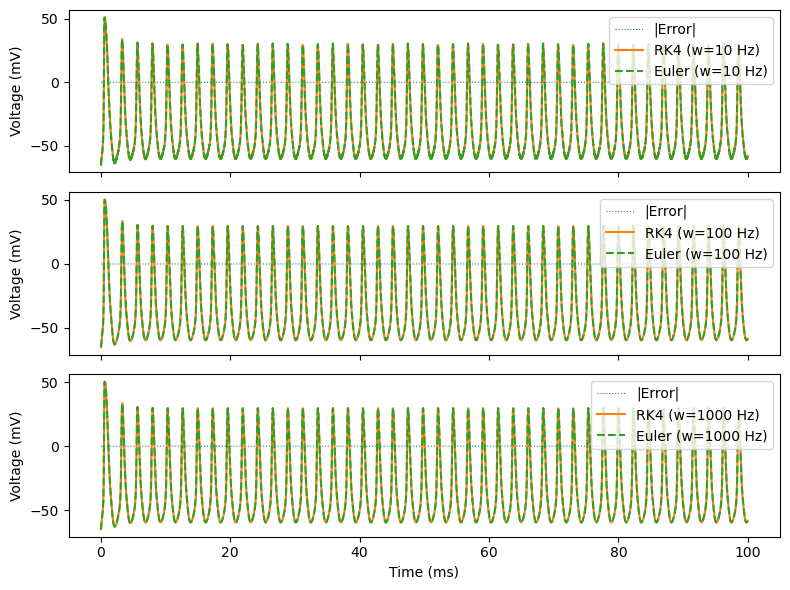

In [85]:
def run_HH_RK2():
    epsilon = 0.01 
    t = np.arange(0, 100, epsilon)
    y0 = np.float64([-65, 0, 1, 0])
    
    w_values = [10, 100, 1000]
    amplitude = 50
    
    fig, ax = plt.subplots(len(w_values), 1, figsize=(8, 6), sharex=True)
    
    def dXdt(X, t, w):

        V, m, h, n = X[0:1], X[1:2], X[2:3], X[3:4]
        I_ext = amplitude * (np.sin(2 * np.pi * w * t)+1)  # External sinusoidal current stimulation

        n0, tn = K_prop(V)
        m0, tm, h0, th = Na_prop(V)
        
        dVdt = (I_ext - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
        dmdt = - (1.0 / tm) * (m - m0)
        dhdt = - (1.0 / th) * (h - h0)
        dndt = - (1.0 / tn) * (n - n0)

        return np.concatenate([dVdt, dmdt, dhdt, dndt], 0)
    
    for i, w in enumerate(w_values):
        state_rk4 = odeint_rk4(lambda X, t: dXdt(X, t, w), y0, t)
        V_rk4 = state_rk4[0]
        
        state_euler = np.zeros_like(state_rk4)
        state_euler[:, 0] = y0
        for j in range(len(t) - 1):
            state_euler[:, j + 1] = state_euler[:, j] + epsilon * dXdt(state_euler[:, j], t[j], w)
        V_euler = state_euler[0]
        
        abs_error = np.abs(V_rk4 - V_euler)
        max_error = np.max(abs_error)
        mean_error = np.mean(abs_error)
        print(f"w = {w} Hz: max error = {max_error:.4f} mV, mean error = {mean_error:.4f} mV")

        ax[i].plot(t, abs_error, label='|Error|', linestyle='dotted', linewidth=0.8)
        ax[i].plot(t, V_rk4, label=f'RK4 (w={w} Hz)', linestyle='solid')
        ax[i].plot(t, V_euler, label=f'Euler (w={w} Hz)', linestyle='dashed')
        ax[i].set_ylabel('Voltage (mV)')
        ax[i].legend()
    
    ax[-1].set_xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()

run_HH_RK2()


## 5: Action Potential

When the inactivation curve shifts to a more positive voltage the sodium channels take longer to close. This means that during depolarization more sodium can enter the cell. The action potential becomes larger and lasts longer. The membrane takes more time to return to its resting state. This change also affects the shape of the action potential and how often the cell can fire again. The inactivation shift changes the timing and size of the action potential and shows how sensitive the system is to changes in gating variables. Small shifts in these curves can change how neurons fire and how signals travel in a network.

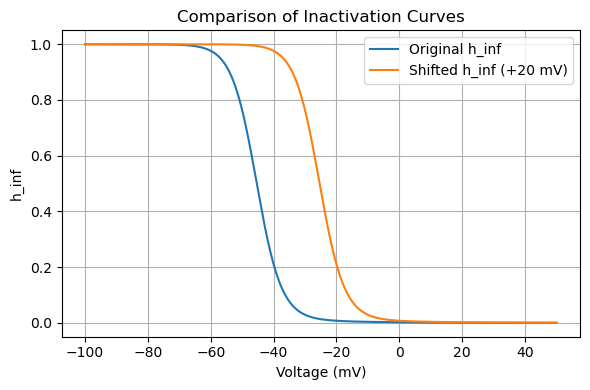

/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_79891/3242589709.py:7: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


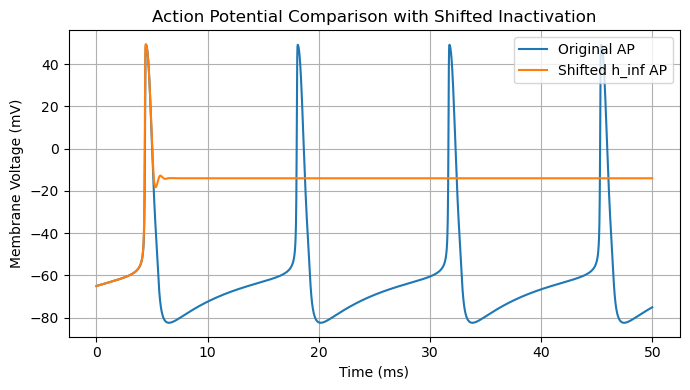

In [93]:
def shifted_h_inf(v):
   
    alpha_h = 0.128 * np.exp(-(v + 30) / 18)  # shifted by +20 mV
    beta_h = 4 / (1 + np.exp(-(v + 7) / 5))   # shifted by +20 mV
    return alpha_h / (alpha_h + beta_h)


def original_h_inf(v):
    
    alpha_h = 0.128 * np.exp(-(v + 50) / 18)
    beta_h = 4 / (1 + np.exp(-(v + 27) / 5))
    return alpha_h / (alpha_h + beta_h)


def plot_inactivation_curves():
    v_vals = np.linspace(-100, 50, 500)
    original = original_h_inf(v_vals)
    shifted = shifted_h_inf(v_vals)

    plt.figure(figsize=(6, 4))
    plt.plot(v_vals, original, label='Original h_inf')
    plt.plot(v_vals, shifted, label='Shifted h_inf (+20 mV)')
    plt.xlabel('Voltage (mV)')
    plt.ylabel('h_inf')
    plt.title('Comparison of Inactivation Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def run_HH_comparison():
    
    epsilon = 0.01
    t = np.arange(0, 50, epsilon)
    y0 = np.float64([-65, 0, 1, 0])
    amplitude = 10
    frequency = 100

    def dXdt(X, t, shifted=False):
        V, m, h, n = X[0:1], X[1:2], X[2:3], X[3:4]
        I_ext = amplitude * np.sin(2 * np.pi * frequency * t)

        n0, tn = K_prop(V)
        m0, tm, h0, th = Na_prop(V)
        if shifted:
            alpha_h = 0.128 * np.exp(-(V + 30) / 18)
            beta_h = 4 / (1 + np.exp(-(V + 7) / 5))
            h0 = alpha_h / (alpha_h + beta_h)
            th = 1 / (alpha_h + beta_h)

        dVdt = (I_ext - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
        dmdt = - (1.0 / tm) * (m - m0)
        dhdt = - (1.0 / th) * (h - h0)
        dndt = - (1.0 / tn) * (n - n0)

        return np.concatenate([dVdt, dmdt, dhdt, dndt], 0)

    # Run simulations
    state_orig = odeint_rk4(lambda X, t: dXdt(X, t, shifted=False), y0, t)
    state_shifted = odeint_rk4(lambda X, t: dXdt(X, t, shifted=True), y0, t)

    V_orig = state_orig[0]
    V_shifted = state_shifted[0]

    plt.figure(figsize=(7, 4))
    plt.plot(t, V_orig, label='Original AP')
    plt.plot(t, V_shifted, label='Shifted h_inf AP',)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Voltage (mV)')
    plt.title('Action Potential Comparison with Shifted Inactivation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_inactivation_curves()

run_HH_comparison()
